<a href="https://colab.research.google.com/github/peteray-dev/RAG_LLM_BusinessTech/blob/master/RAG_with_Neo4j.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi


Fri Jan 31 22:57:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install --upgrade -q langchain langchain-community langchain-openai langchain-experimental neo4j wikipedia tiktoken yfiles_jupyter_graphs

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.7/412.7 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 460.6/460.6 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━

In [3]:
from langchain_core.runnables import (
    RunnableBranch,
    RunnableLambda, RunnableParallel,
    RunnablePassthrough
    )

In [4]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts.prompt import PromptTemplate

In [5]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPEN_API_KEY')

# NEO4J_URI = userdata.get('NEO4J_URI')
# NEO4J_USERNAME = userdata.get('NEO4J_USERNAME')
# NEO4J_PASSWORD = userdata.get('NEO4J_PASSWORD

In [6]:
from  typing import Tuple, List, Optional

In [7]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import ConfigurableField
from yfiles_jupyter_graphs import GraphWidget
from neo4j import GraphDatabase
import os

In [8]:
try:
  import google.colab
  from google.colab import output
  output.enable_custom_widget_manager()
except:
  pass

In [9]:
from langchain_community.vectorstores import Neo4jVector
# from langchain_community.graphs import Neo4j

In [54]:
# NEO4J_URI = "neo4j+s://221fcc54.databases.neo4j.io"
# NEO4J_USERNAME = "neo4j"
# NEO4J_PASSWORD = "ROTiS8erhHl2PlYpagHH1oWvsx91H5VGdQBfe_y2k60"

NEO4J_URI = userdata.get('NEO4J_URI')
NEO4J_USERNAME = userdata.get('NEO4J_USERNAME')
NEO4J_PASSWORD = userdata.get('NEO4J_PASSWORD')

In [11]:
os.environ["NEO4J_URI"] = NEO4J_URI
os.environ["NEO4J_USERNAME"] = NEO4J_USERNAME
os.environ["NEO4J_PASSWORD"] = NEO4J_PASSWORD
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [12]:
from langchain_community.graphs import Neo4jGraph

In [13]:
graph = Neo4jGraph()
#     url=os.environ.get("NEO4J_URI"),
#     username=os.environ.get("NEO4J_USERNAME"),
#     password=os.environ.get("NEO4J_PASSWORD"),
# )

#  in this cas i have called the credentials using the os.environ

<ipython-input-13-c7cc67fa6f03>:1: LangChainDeprecationWarning: The class `Neo4jGraph` was deprecated in LangChain 0.3.8 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-neo4j package and should be used instead. To use it run `pip install -U :class:`~langchain-neo4j` and import as `from :class:`~langchain_neo4j import Neo4jGraph``.
  graph = Neo4jGraph()


In [14]:
#web scrapping
from langchain.document_loaders import WikipediaLoader
raw_document = WikipediaLoader(query="Business Intelligence").load()


/usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [15]:
len(  raw_document)

24

In [16]:
raw_document[0]

Document(metadata={'title': 'Business intelligence', 'summary': 'Business intelligence (BI) consists of strategies, methodologies, and technologies used by enterprises for data analysis and management of business information. Common functions of BI technologies include reporting, online analytical processing, analytics, dashboard development, data mining, process mining, complex event processing, business performance management, benchmarking, text mining, predictive analytics, and prescriptive analytics. \nBI tools can handle large amounts of structured and sometimes unstructured data to help organizations identify, develop, and otherwise create new strategic business opportunities. They aim to allow for the easy interpretation of these big data. Identifying new opportunities and implementing an effective strategy based on insights is assumed to potentially provide businesses with a competitive market advantage and long-term stability, and help them take strategic decisions.\nBusiness 

In [17]:
# instead of storing the embedding in vectorDB, I willlput it in Neo4J because of easy query and
# flexxibitlity search that graph gives connecting chunks or works (nodes) with edges

#Chunking now for 4 document
from langchain.text_splitter import TokenTextSplitter
text_splitter = TokenTextSplitter(chunk_size=512, chunk_overlap=24)
documents = text_splitter.split_documents(raw_document[:4])

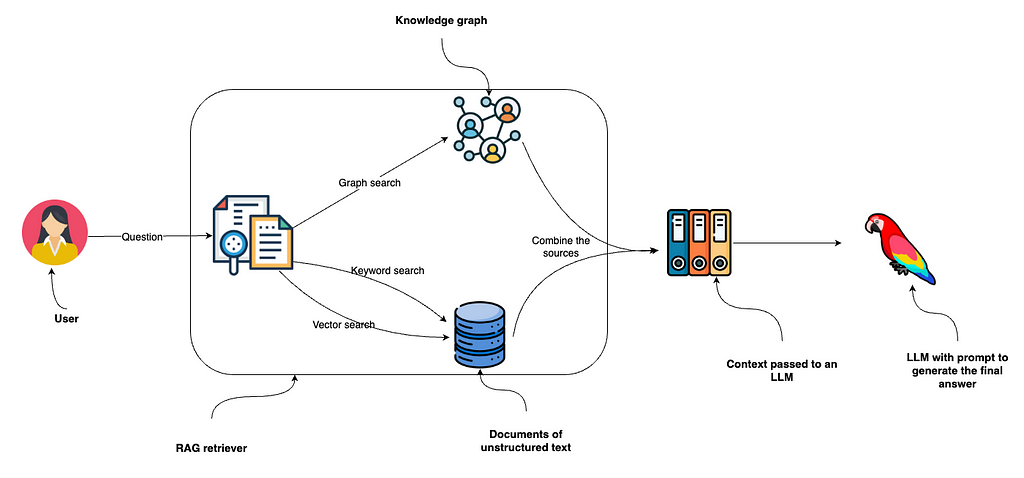

In [18]:
# loading the lLM from openai

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo-0125")




In [19]:
# converting the document to graph
from langchain_experimental.graph_transformers import LLMGraphTransformer
llm_transformer = LLMGraphTransformer(llm=llm)

/usr/local/lib/python3.10/dist-packages/langchain_openai/chat_models/base.py:1375: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo-0125 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


In [20]:
graph_document = llm_transformer.convert_to_graph_documents(documents)

In [21]:
graph_document

[GraphDocument(nodes=[Node(id='Business Intelligence', type='Concept', properties={}), Node(id='Bi Technologies', type='Concept', properties={}), Node(id='Enterprises', type='Organization', properties={}), Node(id='Data Analysis', type='Concept', properties={}), Node(id='Management Of Business Information', type='Concept', properties={}), Node(id='Bi Tools', type='Concept', properties={}), Node(id='Structured Data', type='Concept', properties={}), Node(id='Unstructured Data', type='Concept', properties={}), Node(id='New Strategic Business Opportunities', type='Concept', properties={}), Node(id='Interpretation Of Big Data', type='Concept', properties={}), Node(id='Competitive Market Advantage', type='Concept', properties={}), Node(id='Long-Term Stability', type='Concept', properties={}), Node(id='Strategic Decisions', type='Concept', properties={}), Node(id='Operational Decisions', type='Concept', properties={}), Node(id='Product Positioning', type='Concept', properties={}), Node(id='Pr

In [22]:
# dropping the graph document intothe neo4j database
graph.add_graph_documents(
    graph_document,
    baseEntityLabel=True,
    include_source=True
)

In [23]:
from yfiles_jupyter_graphs import GraphWidget
from neo4j import GraphDatabase


In [24]:
# querying neo4j database using cypher syntax
# exploring connections in a knowledge graph, e.g., finding which people or documents mention each other.

default_cypher = "MATCH (s)-[r:!MENTIONS]->(t) RETURN s, r, t LIMIT 50"


In [25]:
def showGraph(cypher:str = default_cypher):
  # creating neo4j session
  driver = GraphDatabase.driver(
      uri=os.environ['NEO4J_URI'],
      auth=(os.environ['NEO4J_USERNAME'],
            os.environ['NEO4J_PASSWORD']))
  session = driver.session()
  widget_dr =  GraphWidget(graph=session.run(cypher).graph())
  widget_dr.node_label_mapping = 'id'
  display(widget_dr)
  return widget_dr


In [26]:
showGraph()

GraphWidget(layout=Layout(height='800px', width='100%'))

GraphWidget(layout=Layout(height='800px', width='100%'))

In [27]:
from typing import List, Optional, Tuple

In [28]:
graph.query("CREATE FULLTEXT INDEX entity IF NOT EXISTS FOR (e:__Entity__) ON EACH [e.id]")

[]

In [29]:
#Embedding the document  and creating vector
from langchain_community.vectorstores import Neo4jVector
from langchain.embeddings import OpenAIEmbeddings

vector_index = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(),
    search_type='hybrid',
    node_label='Document',
    text_node_properties=['text'],
    embedding_node_property='embedding'
)

<ipython-input-29-02bcf096b5f3>:6: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  OpenAIEmbeddings(),


In [30]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts.prompt import PromptTemplate

In [31]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are extracting organization and person entities from the text."
        ),
        (
            "human",
            "Use the following format to extract information from the following"
            "input: {question}",
        )
    ]
)

In [32]:
# creating an entity
from langchain_core.pydantic_v1 import BaseModel, Field
# Extract entities from text
class Entities(BaseModel):
    """Entities from text."""

    names:List[str] = Field(
        ...,
        description = "All the entities that appear in the text"
    )
# i can exempt some entities

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [33]:

entity_chain = prompt | llm.with_structured_output(Entities)

/usr/local/lib/python3.10/dist-packages/langchain_openai/chat_models/base.py:1362: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_openai/chat_models/base.py:1375: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo-0125 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


In [40]:
#giving me the entity, name. all meaniful entities are extracted from the text
entity_chain.invoke({'question': 'What is business ?'}).names

['business']

In [41]:
from langchain_community.vectorstores.neo4j_vector import remove_lucene_chars

def generate_full_text_query(input: str) -> str:
    full_text_query = ""
    words = [el for el in remove_lucene_chars(input).split() if el] #remove special character and spit into separate words
    for word in words[:-1]: #remove the last word
        full_text_query += f" {word}~2 AND" # make a fuzzy matching, just to make it work even if the spelling is wrong, the add 'AND'
    full_text_query += f" {words[-1]}~2" # add the last word
    return full_text_query.strip() #retrun word and remove extra spaces


In [45]:
# print(generate_full_text_query("Business Intelligence"))

Business~2 AND Intelligence~2


In [51]:
# Fulltext index query
def structured_retriever(question: str) -> str:
    result = ""
    entities = entity_chain.invoke({"question": question})
    for entity in entities.names:
        response = graph.query(
            """CALL db.index.fulltext.queryNodes('entity', $query, {limit:2})
            YIELD node,score
            CALL {
              WITH node
              MATCH (node)-[r:!MENTIONS]->(neighbor)
              RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS output
              UNION ALL
              WITH node
              MATCH (node)<-[r:!MENTIONS]-(neighbor)
              RETURN neighbor.id + ' - ' + type(r) + ' -> ' +  node.id AS output
            }
            RETURN output LIMIT 50
            """,
            {"query": generate_full_text_query(entity)},
        )
        result += "\n".join([el['output'] for el in response])
    return result

In [52]:
print(structured_retriever("What is Business Intelligence?"))

Business Intelligence - CONSISTS_OF -> Bi Technologies
Business Intelligence - SUPPORTS -> Business Decisions
Hans Peter Luhn - MENTIONED_IN -> Business Intelligence
Howard Dresner - PROPOSED_DEFINITION -> Business Intelligence
Solomon Negash - DEFINED_AS -> Business Intelligence
Paul Gray - DEFINED_AS -> Business Intelligence
Forrester Research - DEFINED_AS -> Business Intelligence
Agile Business Intelligence - INTEGRATION -> Business Intelligence
Financial Intelligence - TYPE_OF -> Business Intelligence
Business Intelligence Software - BELONGS_TO_CATEGORY -> Data Warehouse
Business Intelligence Software - BELONGS_TO_CATEGORY -> Spreadsheets
Business Intelligence Software - BELONGS_TO_CATEGORY -> Reporting And Querying Software
Business Intelligence Software - BELONGS_TO_CATEGORY -> Online Analytical Processing (Olap)
Business Intelligence Software - BELONGS_TO_CATEGORY -> Digital Dashboards
Business Intelligence Software - BELONGS_TO_CATEGORY -> Data Mining
Business Intelligence Soft

In [68]:
def retriever(question: str):
    print(f"Search query: {question}")
    structured_data = structured_retriever(question)
    unstructured_data = [el.page_content for el in vector_index.similarity_search(question)]
    final_data = f"""Structured data:
{structured_data}
Unstructured data:
{"#Document ". join(unstructured_data)}
    """
    return final_data

In [53]:
_template = """Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question,
in its original language.
Chat History:
{chat_history}
Follow Up Input: {question}
Standalone question:"""

In [62]:
# This is used to rephrase follow-up questions into standalone questions.

CONDENSE_QUESTION_PROMPT = PromptTemplate.from_template(_template)

In [63]:
# LLMs don’t have memory by default—this function helps maintain context.
# Ensures that follow-up questions make sense.
def _format_chat_history(chat_history: List[Tuple[str, str]]) -> List:
    buffer = []
    for human, ai in chat_history:
        buffer.append(HumanMessage(content=human))
        buffer.append(AIMessage(content=ai))
    return buffer

In [64]:
"""
  If chat history exists → The chatbot condenses the chat history + follow-up question into a standalone question.
If no chat history exists → The chatbot directly uses the provided question.
"""
_search_query = RunnableBranch(
    # If input includes chat_history, we condense it with the follow-up question
    (
        RunnableLambda(lambda x: bool(x.get("chat_history"))).with_config(
            run_name="HasChatHistoryCheck"
        ),  # Condense follow-up question and chat into a standalone_question
        RunnablePassthrough.assign(
            chat_history=lambda x: _format_chat_history(x["chat_history"])
        )
        | CONDENSE_QUESTION_PROMPT #convert to stand alone
        | ChatOpenAI(temperature=0) #send it to openai
        | StrOutputParser(), # pass the output as string
    ),
    # Else, we have no chat history, so just pass through the question
    RunnableLambda(lambda x : x["question"]),
)

In [65]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
Use natural language and be concise.
Answer:"""

In [70]:
prompt = ChatPromptTemplate.from_template(template) #insert into langchain and Allows dynamic insertion of context and question variables.


In [71]:
# Retriever and generation chain
chain = (
    RunnableParallel(
        {
            "context": _search_query | retriever,  # get the context from retrieval sytem
            "question": RunnablePassthrough(), # pass user original question
        }
    )
    | prompt
    | llm
    | StrOutputParser()
)

In [73]:
chain.invoke({"question": "Which tools are used in busineess intelligence?"})

Search query: Which tools are used in busineess intelligence?


'Spreadsheets, reporting and querying software, online analytical processing (OLAP), digital dashboards, data mining, business activity monitoring, data warehouse, local information systems, data cleansing.'

In [74]:
chain.invoke(
    {
        "question": "what is OLAP?",
        "chat_history": [("Which tools are used in busineess intelligence?", "Spreadsheets, reporting and querying software, online analytical processing (OLAP), digital dashboards, data mining, business activity monitoring, data warehouse, local information systems, data cleansing")],
    }
)

Search query: What is OLAP?


'OLAP stands for Online Analytical Processing and is a key tool used in business intelligence for analyzing and reporting data.'